In [23]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))]),
)

validation_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))]),
)


Files already downloaded and verified
Files already downloaded and verified


In [24]:
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as F


class VectorQuantizer(nn.Module):
    """
    From an encoding, find the closest embedding from the code book 

    :param num_embeddings: Number of embeddings in the codebook
    :param embedding_dim: Size of the embedding
    :param commitment_cost: Weight of the commitment in the loss computation
    """
    def __init__(self, num_embeddings: int, embedding_dim: int, commitment_cost: int):
        super(VectorQuantizer, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.codebook = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.codebook.weight.data.uniform_(-1 / self.num_embeddings, 1 / self.num_embeddings)
        self.commitment_cost = commitment_cost

    def forward(self, inputs: Tensor):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1)
        input_shape = inputs.shape

        # Flatten input (B x H x W x C) to (B*H*W x C)
        flat_input = inputs.reshape(-1, self.embedding_dim)

        # Calculate distances: result size: B*H*W x num_embeddings
        distances = torch.cdist(flat_input, self.codebook.weight)

        # Encoding
        encodings_idxs = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encodings_idxs, num_classes=self.num_embeddings).float()

        # Quantize and unflatten
        quantized = self.codebook(encodings_idxs).view(input_shape)
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2), perplexity, encodings


In [25]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=in_channels, out_channels=num_residual_hiddens, kernel_size=3, stride=1, padding=1, bias=False
            ),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens, out_channels=num_hiddens, kernel_size=1, stride=1, bias=False),
        )

    def forward(self, x):
        return x + self.block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList(
            [Residual(in_channels, num_hiddens, num_residual_hiddens) for _ in range(self.num_residual_layers)]
        )

    def forward(self, x):
        for i in range(self.num_residual_layers):
            x = self.layers[i](x)
        return F.relu(x)


In [26]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens // 2, kernel_size=4, stride=2, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=num_hiddens // 2, out_channels=num_hiddens, kernel_size=4, stride=2, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=num_hiddens, out_channels=num_hiddens, kernel_size=3, stride=1, padding=1)
        self.residual_stack = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
        )

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = F.relu(x)

        x = self.conv_2(x)
        x = F.relu(x)

        x = self.conv_3(x)
        return self.residual_stack(x)


In [27]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens, kernel_size=3, stride=1, padding=1)

        self.residual_stack = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
        )

        self.conv_trans_1 = nn.ConvTranspose2d(
            in_channels=num_hiddens, out_channels=num_hiddens // 2, kernel_size=4, stride=2, padding=1
        )

        self.conv_trans_2 = nn.ConvTranspose2d(
            in_channels=num_hiddens // 2, out_channels=3, kernel_size=4, stride=2, padding=1
        )

    def forward(self, inputs):
        x = self.conv_1(inputs)

        x = self.residual_stack(x)

        x = self.conv_trans_1(x)
        x = F.relu(x)

        return self.conv_trans_2(x)


In [28]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.0  # 0.99


In [29]:
from torch.utils.data import DataLoader

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True, pin_memory=True)


In [30]:
class Model(nn.Module):
    def __init__(
        self, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay=0
    ):
        super(Model, self).__init__()

        self.encoder = Encoder(3, num_hiddens, num_residual_layers, num_residual_hiddens)
        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1, stride=1)
        if decay > 0.0:
            self.vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost, decay)
        else:
            self.vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        loss, quantized, perplexity, _ = self.vq_vae(z)
        x_recon = self.decoder(quantized)

        return loss, x_recon, perplexity


In [31]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to("cuda")

In [32]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=False)


In [33]:
import numpy as np

data_variance = np.var(training_data.data / 255.0)

model.train()
train_res_recon_error = []
train_res_perplexity = []

for epoch in range(3000):
    (data, _) = next(iter(training_loader))
    data = data.to("cuda")

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (epoch + 1) % 100 == 0:
        print(
            "Epoch {:d}  recon_error: {:.3f}  perplexity: {:.3f}".format(
                epoch + 1, np.mean(train_res_recon_error[-100:]), np.mean(train_res_perplexity[-100:])
            )
        )


Epoch 100  recon_error: 0.611  perplexity: 2.321
Epoch 200  recon_error: 0.440  perplexity: 2.783
Epoch 300  recon_error: 0.410  perplexity: 4.304
Epoch 400  recon_error: 0.334  perplexity: 4.205
Epoch 500  recon_error: 0.292  perplexity: 6.511
Epoch 600  recon_error: 0.261  perplexity: 7.912
Epoch 700  recon_error: 0.239  perplexity: 10.286
Epoch 800  recon_error: 0.217  perplexity: 14.757
Epoch 900  recon_error: 0.207  perplexity: 18.338
Epoch 1000  recon_error: 0.195  perplexity: 19.417
Epoch 1100  recon_error: 0.187  perplexity: 20.254
Epoch 1200  recon_error: 0.179  perplexity: 21.596
Epoch 1300  recon_error: 0.173  perplexity: 23.701
Epoch 1400  recon_error: 0.169  perplexity: 26.256
Epoch 1500  recon_error: 0.163  perplexity: 27.985
Epoch 1600  recon_error: 0.161  perplexity: 29.143
Epoch 1700  recon_error: 0.158  perplexity: 30.252
Epoch 1800  recon_error: 0.156  perplexity: 31.793
Epoch 1900  recon_error: 0.153  perplexity: 33.539
Epoch 2000  recon_error: 0.150  perplexity: 35

In [34]:
import matplotlib.pyplot as plt

model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to("cuda")

vq_output_eval = model.pre_vq_conv(model.encoder(valid_originals))
_, valid_quantize, _, _ = model.vq_vae(vq_output_eval)
valid_reconstructions = model.decoder(valid_quantize)
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to("cuda")
_, train_reconstructions, _, _ = model.vq_vae(train_originals)


def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


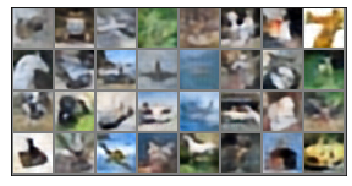

In [35]:
from torchvision.utils import make_grid

show(make_grid(valid_reconstructions.cpu().data)+0.5, )


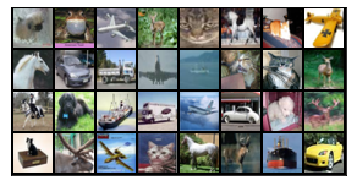

In [36]:
show(make_grid(valid_originals.cpu()+0.5))